# Comparing the Smoothed Label Effect of Different Models

## Imports

In [1]:
import sys
sys.executable

'/opt/miniconda3/bin/python'

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from scipy import stats
import seaborn as sns

## Loading Storaged Experiment Results

In [14]:
save_dir = 'LS_exp/'
compare = ['ngram', 'boe', 'attn', 'bert', 'ulmfit']
seeds = [0,1,2,42,100,233,1024,1337,2333,4399]
metrics = ['val_1_acc', 'val_k_acc']

In [15]:
exp = {}
for model in compare:
    exp[model] = {}
    for seed in seeds:
        exp[model][seed] = {}
        now_dir = save_dir+model+'/'+str(seed)+'/'
        try:
            with open(now_dir+'hyperdict_fuzzy.p', 'rb') as fp:
                hyperdict = pickle.load(fp)
                
            for key in hyperdict.keys():
                temp_dict={}
                #temp_dict['best_k'] = hyperdict[key]['early_stopping_best_k_acc_val']
                temp_dict['val_1_acc'] = hyperdict[key]['val_1_acc']
                temp_dict['val_k_acc'] = hyperdict[key]['val_k_acc']
                temp_dict['val_k_jac'] = hyperdict[key]['val_k_jac']
                temp_dict['train_1_acc'] = hyperdict[key]['train_1_acc']
                temp_dict['train_k_acc'] = hyperdict[key]['train_k_acc']
                temp_dict['train_k_jac'] = hyperdict[key]['train_k_jac']
                exp[model][seed][key] = temp_dict                
        except:
            continue

In [16]:
keys = list(exp['boe'][0].keys())
keys

[('uni', 0),
 ('uni', 0.01),
 ('uni', 0.05),
 ('uni', 0.1),
 ('uni', 0.2),
 ('uni', 0.5),
 ('uni', 1),
 ('prior', 0),
 ('prior', 0.01),
 ('prior', 0.05),
 ('prior', 0.1),
 ('prior', 0.2),
 ('prior', 0.5),
 ('prior', 1),
 ('origin', 0),
 ('origin', 0.01),
 ('origin', 0.05),
 ('origin', 0.1),
 ('origin', 0.2),
 ('origin', 0.5),
 ('origin', 1)]

## Dealing with Data

### Creating Dataframe

In [17]:
exp_df = pd.DataFrame.from_dict({(i,k,j): exp[i][j][k] for i in exp.keys()
                                                for j in exp[i].keys()
                                                for k in exp[i][j].keys()}, orient ='index')

In [18]:
exp_df['val_1_acc'] = exp_df['val_1_acc'].apply(lambda x: np.array(x))
exp_df['val_k_acc'] = exp_df['val_k_acc'].apply(lambda x: np.array(x))
exp_df['val_k_jac'] = exp_df['val_k_jac'].apply(lambda x: np.array(x))
exp_df['train_1_acc'] = exp_df['train_1_acc'].apply(lambda x: np.array(x))
exp_df['train_k_acc'] = exp_df['train_k_acc'].apply(lambda x: np.array(x))
exp_df['train_k_jac'] = exp_df['train_k_jac'].apply(lambda x: np.array(x))

In [19]:
exp_df['best_k'] = exp_df['val_k_acc'].apply(lambda x: np.array(x).max())
exp_df['best_k_id'] = exp_df['val_k_acc'].apply(lambda x: np.array(x).argmax())
exp_df['best_1'] = exp_df['val_1_acc'].apply(lambda x: np.array(x).max())
exp_df['best_jac'] = exp_df['val_k_jac'].apply(lambda x: np.array(x).max())

In [34]:
exp_df.loc['bert'].loc[('uni', 0)]

,val_1_acc,val_k_acc,val_k_jac,train_1_acc,train_k_acc,train_k_jac,best_k,best_k_id,best_1,best_jac
0,"[57.8125, 68.75, 72.0703125, 71.484375, 70.117...","[86.9140625, 92.3828125, 92.1875, 92.578125, 9...","[0.23611886240541935, 0.25068359822034836, 0.2...","[35.53571428571429, 62.58928571428572, 72.5, 7...","[70.84821428571428, 92.16517857142856, 95.8705...","[0.20384619890579156, 0.2367995343038014, 0.25...",93.359375,4,72.070312,0.337435
1,"[63.8671875, 71.484375, 73.2421875, 72.65625, ...","[87.6953125, 93.1640625, 94.3359375, 93.554687...","[0.2341796904802322, 0.253092460334301, 0.2738...","[36.87500000000001, 62.94642857142857, 72.8571...","[71.40625000000001, 92.18750000000001, 95.6919...","[0.21874601798398152, 0.2487885353820664, 0.26...",94.335938,2,73.242188,0.341536
2,"[58.7890625, 70.3125, 73.2421875, 70.8984375, ...","[88.8671875, 92.3828125, 92.578125, 91.9921875...","[0.24597982689738274, 0.26126303151249886, 0.2...","[34.33035714285714, 62.299107142857146, 73.325...","[67.47767857142857, 92.23214285714283, 95.6919...","[0.18981992474624088, 0.24844786758933754, 0.2...",92.578125,2,73.242188,0.349316
42,"[49.8046875, 70.8984375, 72.65625000000001, 71...","[89.2578125, 92.578125, 93.359375, 93.1640625,...","[0.2056710422039032, 0.23634672723710537, 0.24...","[35.49107142857144, 60.55803571428572, 72.0312...","[71.51785714285714, 93.05803571428572, 95.8035...","[0.17323910413043836, 0.21872909622532982, 0.2...",93.359375,2,72.656250,0.324447
100,"[54.6875, 70.1171875, 70.3125, 70.703125, 71.4...","[86.5234375, 92.96875, 92.96875, 92.7734374999...","[0.23535156436264515, 0.24371745623648167, 0.2...","[36.160714285714285, 61.38392857142857, 72.343...","[72.12053571428572, 92.00892857142858, 95.6250...","[0.18764314172523364, 0.23748140249933508, 0.2...",92.968750,1,71.484375,0.325521
233,"[52.734375, 71.09375, 71.484375, 71.09375, 69....","[85.15625, 91.40625, 93.1640625, 92.578125, 91...","[0.21718052588403225, 0.24850261211395264, 0.2...","[34.910714285714285, 62.20982142857142, 73.593...","[70.2455357142857, 92.45535714285714, 96.13839...","[0.18849481216498784, 0.23937606705086575, 0.2...",93.164062,2,73.437500,0.311900
1024,"[52.5390625, 68.9453125, 71.2890625, 68.75, 70...","[86.5234375, 90.62500000000001, 92.57812499999...","[0.21768973022699356, 0.2342866491526365, 0.24...","[33.77232142857142, 59.33035714285717, 71.0267...","[67.94642857142857, 89.59821428571432, 94.9330...","[0.18815210679812094, 0.22927827877657755, 0.2...",92.773438,5,72.460937,0.341699
1337,"[54.4921875, 67.96875, 71.09375, 73.6328125, 7...","[86.1328125, 91.796875, 92.3828125, 92.96875, ...","[0.2351562473922968, 0.25143229588866234, 0.26...","[34.88839285714286, 59.57589285714286, 70.5133...","[68.61607142857144, 91.42857142857144, 95.0223...","[0.19539452376110214, 0.24335751746382034, 0.2...",94.335937,4,73.632812,0.351139
2333,"[56.4453125, 70.31250000000001, 73.046875, 71....","[86.1328125, 91.9921875, 92.1875, 93.359375, 9...","[0.22744141332805157, 0.2502278685569763, 0.26...","[36.875, 60.64732142857144, 73.50446428571432,...","[69.37500000000001, 92.1875, 95.58035714285718...","[0.19395417304975643, 0.23933390144790923, 0.2...",93.554688,6,73.046875,0.371470
4399,"[56.0546875, 69.53124999999999, 72.8515625, 69...","[87.3046875, 92.1875, 94.14062500000001, 92.38...","[0.227966895326972, 0.24640532582998276, 0.259...","[35.959821428571416, 62.05357142857142, 72.165...","[69.33035714285717, 91.78571428571426, 95.2901...","[0.1857444927096367, 0.23355229880128592, 0.24...",94.921875,4,73.046875,0.324433


### Calculating Mean and Standard Deviation

In [22]:
exp_agg = exp_df.groupby(level=(0,1)).mean()
exp_agg['best_k_std'] = exp_df['best_k'].groupby(level=(0,1)).std()
exp_agg['best_1_std'] = exp_df['best_1'].groupby(level=(0,1)).std()
exp_agg['best_jac_std'] = exp_df['best_jac'].groupby(level=(0,1)).std()
exp_agg['num'] = exp_df['best_k'].groupby(level=(0,1)).count()
exp_agg['combined'] = ((exp_agg['best_k'] - 1.96* exp_agg['best_k_std']/np.sqrt(exp_agg['num']))
                       +(exp_agg['best_1'] - 1.96* exp_agg['best_1_std']/np.sqrt(exp_agg['num'])))
exp_agg['best_k_interval'] = 1.96 * exp_agg['best_k_std']/np.sqrt(exp_agg['num'])
exp_agg['best_1_interval'] = 1.96 * exp_agg['best_1_std']/np.sqrt(exp_agg['num'])
exp_agg['best_jac_interval'] = 1.96 * exp_agg['best_jac_std']/np.sqrt(exp_agg['num'])
exp_agg

best_k  best_k_id     best_1  best_jac  best_k_std  \
attn   (origin, 0)     89.882812  12.900000  64.160156  0.207201    0.735418   
       (origin, 0.01)  89.980469   9.300000  64.804688  0.233248    0.560426   
       (origin, 0.05)  89.687500   8.700000  65.957031  0.275672    0.588104   
       (origin, 0.1)   89.589844   7.600000  66.210938  0.295156    0.657842   
       (origin, 0.2)   89.003906   8.100000  66.191406  0.318926    0.545089   
...                          ...        ...        ...       ...         ...   
ulmfit (uni, 0.05)     94.218750   4.200000  69.960938  0.210659    0.452930   
       (uni, 0.1)      94.296875   4.800000  69.707031  0.204662    0.535281   
       (uni, 0.2)      94.082031   4.300000  69.726562  0.273627    0.391167   
       (uni, 0.5)      93.613281   4.000000  69.003906  0.488241    0.695427   
       (uni, 1)        93.402778   3.111111  68.901910  0.491626    0.623608   

                       best_1_std  best_jac_std  num    combined  \
attn   (origin, 0)       0.819641      0.004039   10  153.079134   
       (origin, 0.01)    1.020288      0.004126   10  153.805420   
       (origin, 0.05)    1.193557      0.011042   10  154.540247   
       (origin, 0.1)     1.327870      0.017973   10  154.570024   
       (origin, 0.2)     1.121796      0.019274   10  154.162166   
...                           ...           ...  ...         ...   
ulmfit (uni, 0.05)       0.758121      0.003918   10  163.429070   
       (uni, 0.1)        0.805031      0.004223   10  163.173172   
       (uni, 0.2)        1.452859      0.005665   10  162.665655   
       (uni, 0.5)        1.255852      0.007108   10  161.407772   
       (uni, 1)          0.914939      0.007607    9  161.299503   

                       best_k_interval  best_1_interval  best_jac_interval  
attn   (origin, 0)            0.455817         0.508018           0.002504  
       (origin, 0.01)         0.347355         0.632381           0.002557  
       (origin, 0.05)         0.364510         0.739774           0.006844  
       (origin, 0.1)          0.407735         0.823022           0.011140  
       (origin, 0.2)          0.337850         0.695296           0.011946  
...                                ...              ...                ...  
ulmfit (uni, 0.05)            0.280729         0.469888           0.002428  
       (uni, 0.1)             0.331771         0.498963           0.002617  
       (uni, 0.2)             0.242448         0.900491           0.003511  
       (uni, 0.5)             0.431030         0.778385           0.004406  
       (uni, 1)               0.407424         0.597760           0.004970  

[105 rows x 12 columns]

In [33]:
exp_agg.loc['bert']

,best_k,best_k_id,best_1,best_jac,best_k_std,best_1_std,best_jac_std,num,combined,best_k_interval,best_1_interval,best_jac_interval
"(origin, 0)",93.535156,3.2,72.832031,0.337890,0.761747,0.666801,0.017166,10,165.481764,0.472135,0.413288,0.010640
"(origin, 0.01)",93.535156,3.3,73.085938,0.391745,0.570916,0.735418,0.017852,10,165.811420,0.353857,0.455817,0.011064
"(origin, 0.05)",93.632812,2.1,72.910156,0.494662,0.632550,0.765078,0.031339,10,165.676710,0.392058,0.474200,0.019424
"(origin, 0.1)",93.535156,1.9,73.242188,0.525891,0.709904,0.603751,0.031063,10,165.963132,0.440003,0.374209,0.019253
"(origin, 0.2)",93.535156,2.0,73.261719,0.556100,0.913549,0.783688,0.034189,10,165.744917,0.566223,0.485735,0.021191
"(origin, 0.5)",93.535156,2.2,73.496094,0.598169,0.963234,0.460816,0.025392,10,166.148615,0.597018,0.285617,0.015738
"(origin, 1)",93.496094,2.1,73.125000,0.617071,0.759518,0.625813,0.018682,10,165.762457,0.470754,0.387883,0.011579
"(prior, 0)",93.535156,3.2,72.832031,0.337890,0.761747,0.666801,0.017166,10,165.481764,0.472135,0.413288,0.010640
"(prior, 0.01)",93.339844,5.2,72.988281,0.327128,0.750536,0.868842,0.012387,10,165.324424,0.465187,0.538514,0.007678
"(prior, 0.05)",93.437500,4.3,72.929688,0.288762,0.652342,0.514282,0.011832,10,165.644106,0.404326,0.318755,0.007334


### Keys for Indexing

In [24]:
key0 = keys[1:7]
key0

[('uni', 0.01),
 ('uni', 0.05),
 ('uni', 0.1),
 ('uni', 0.2),
 ('uni', 0.5),
 ('uni', 1)]

In [25]:
key1 = keys[15:]
key1

[('origin', 0.01),
 ('origin', 0.05),
 ('origin', 0.1),
 ('origin', 0.2),
 ('origin', 0.5),
 ('origin', 1)]

In [26]:
key2 = keys[8:14]
key2

[('prior', 0.01),
 ('prior', 0.05),
 ('prior', 0.1),
 ('prior', 0.2),
 ('prior', 0.5),
 ('prior', 1)]

In [28]:
exp_agg.loc['boe']['best_k'].drop([keys[0]]+[keys[7]]+keys[14:],axis=0)

(prior, 0.01)    92.187500
(prior, 0.05)    92.148438
(prior, 0.1)     91.992188
(prior, 0.2)     91.757812
(prior, 0.5)     91.718750
(prior, 1)       90.195312
(uni, 0.01)      92.324219
(uni, 0.05)      91.933594
(uni, 0.1)       91.953125
(uni, 0.2)       91.718750
(uni, 0.5)       91.621094
(uni, 1)         91.738281
Name: best_k, dtype: float64

## Drawing

In [29]:
def get_lines(exp_df, model, key, seeds, SHOW_LAST, K=0):
    ct=0
    rec = pd.DataFrame()
    avg = pd.Series(np.zeros(SHOW_LAST))
    for seed in seeds:
        try:
            if K==0:
                now = pd.Series(exp_df.loc[model].loc[key]['val_k_acc'][seed])[-SHOW_LAST:]
            else:
                now = pd.Series(exp_df.loc[model].loc[key]['val_1_acc'][seed])[-SHOW_LAST:]
            rec[seed] = pd.Series(np.zeros(SHOW_LAST))
            for i in range(SHOW_LAST):
                avg.iloc[i] += now.iloc[i]
                rec[seed].iloc[i] = now.iloc[i]
            ct+=1
        except:
            continue
    avg = avg/ct
    ci = 1.96*rec.T.std()/np.sqrt(len(rec.T))
    return avg, ci

def draw_this(avg, ci, SHOW_LAST, color, marker, label, markersize):
    plt.plot(pd.Series(range(SHOW_LAST)),avg,c=color, marker=marker, alpha=1, 
             label = label, markersize=markersize)
    plt.fill_between(pd.Series(range(SHOW_LAST)), (avg-ci), (avg+ci), color=color, alpha=.031)

def draw_sub(exp_df,exp_agg,model,name=None,SHOW_LAST = 12,draw=None, seeds=seeds, K=0):
    
    arg_2 = exp_agg.loc[model]['combined'].iloc[15:].argmax()
    arg_3 = exp_agg.loc[model]['combined'].drop(keys[0:15],axis=0).argmax()
    arg_4 = exp_agg.loc[model]['combined'].iloc[8:14].argmax()
    key = {}
    key[0] = ('uni',0)
    key[1] = key1[arg_3]
    key[2] = key0[arg_2]
    key[3] = key2[arg_4]
    if draw:
        key[1] = draw
   
    colors = ['dodgerblue','darkgreen','darkorange','darkred']
    markers = [('*',18),  ('o',12), ('^',15), ('x',15)]
    labels = ['w/o LS','vanilla ','uniform ','prior ']
    
    for i in range(len(key)):
        avg,ci = get_lines(exp_df, model, key[i], seeds, SHOW_LAST, K=K)
        if i==0:
            label = labels[i]
        else:
            label = labels[i] + str(key[i][1])
        draw_this(avg, ci, SHOW_LAST, colors[i], markers[i][0], label, markers[i][1])

    plt.legend(frameon=False)
    if K==0:
        plt.ylim(85,95)        
        plt.title(model + ' val_k_acc')
        plt.ylabel('Top-k Accuracy',size=42)
    else:
        plt.ylim(60,75)
        plt.title(model + ' val_1_acc')
        plt.ylabel('Top-1 Accuracy',size=42)
    
    plt.xlabel('{} Epochs before Early-Stopping'.format(SHOW_LAST),size=42)
    
    plt.tick_params(labelsize=32)
    plt.title(name, size=45)
    plt.legend(frameon=False, fontsize = 42)

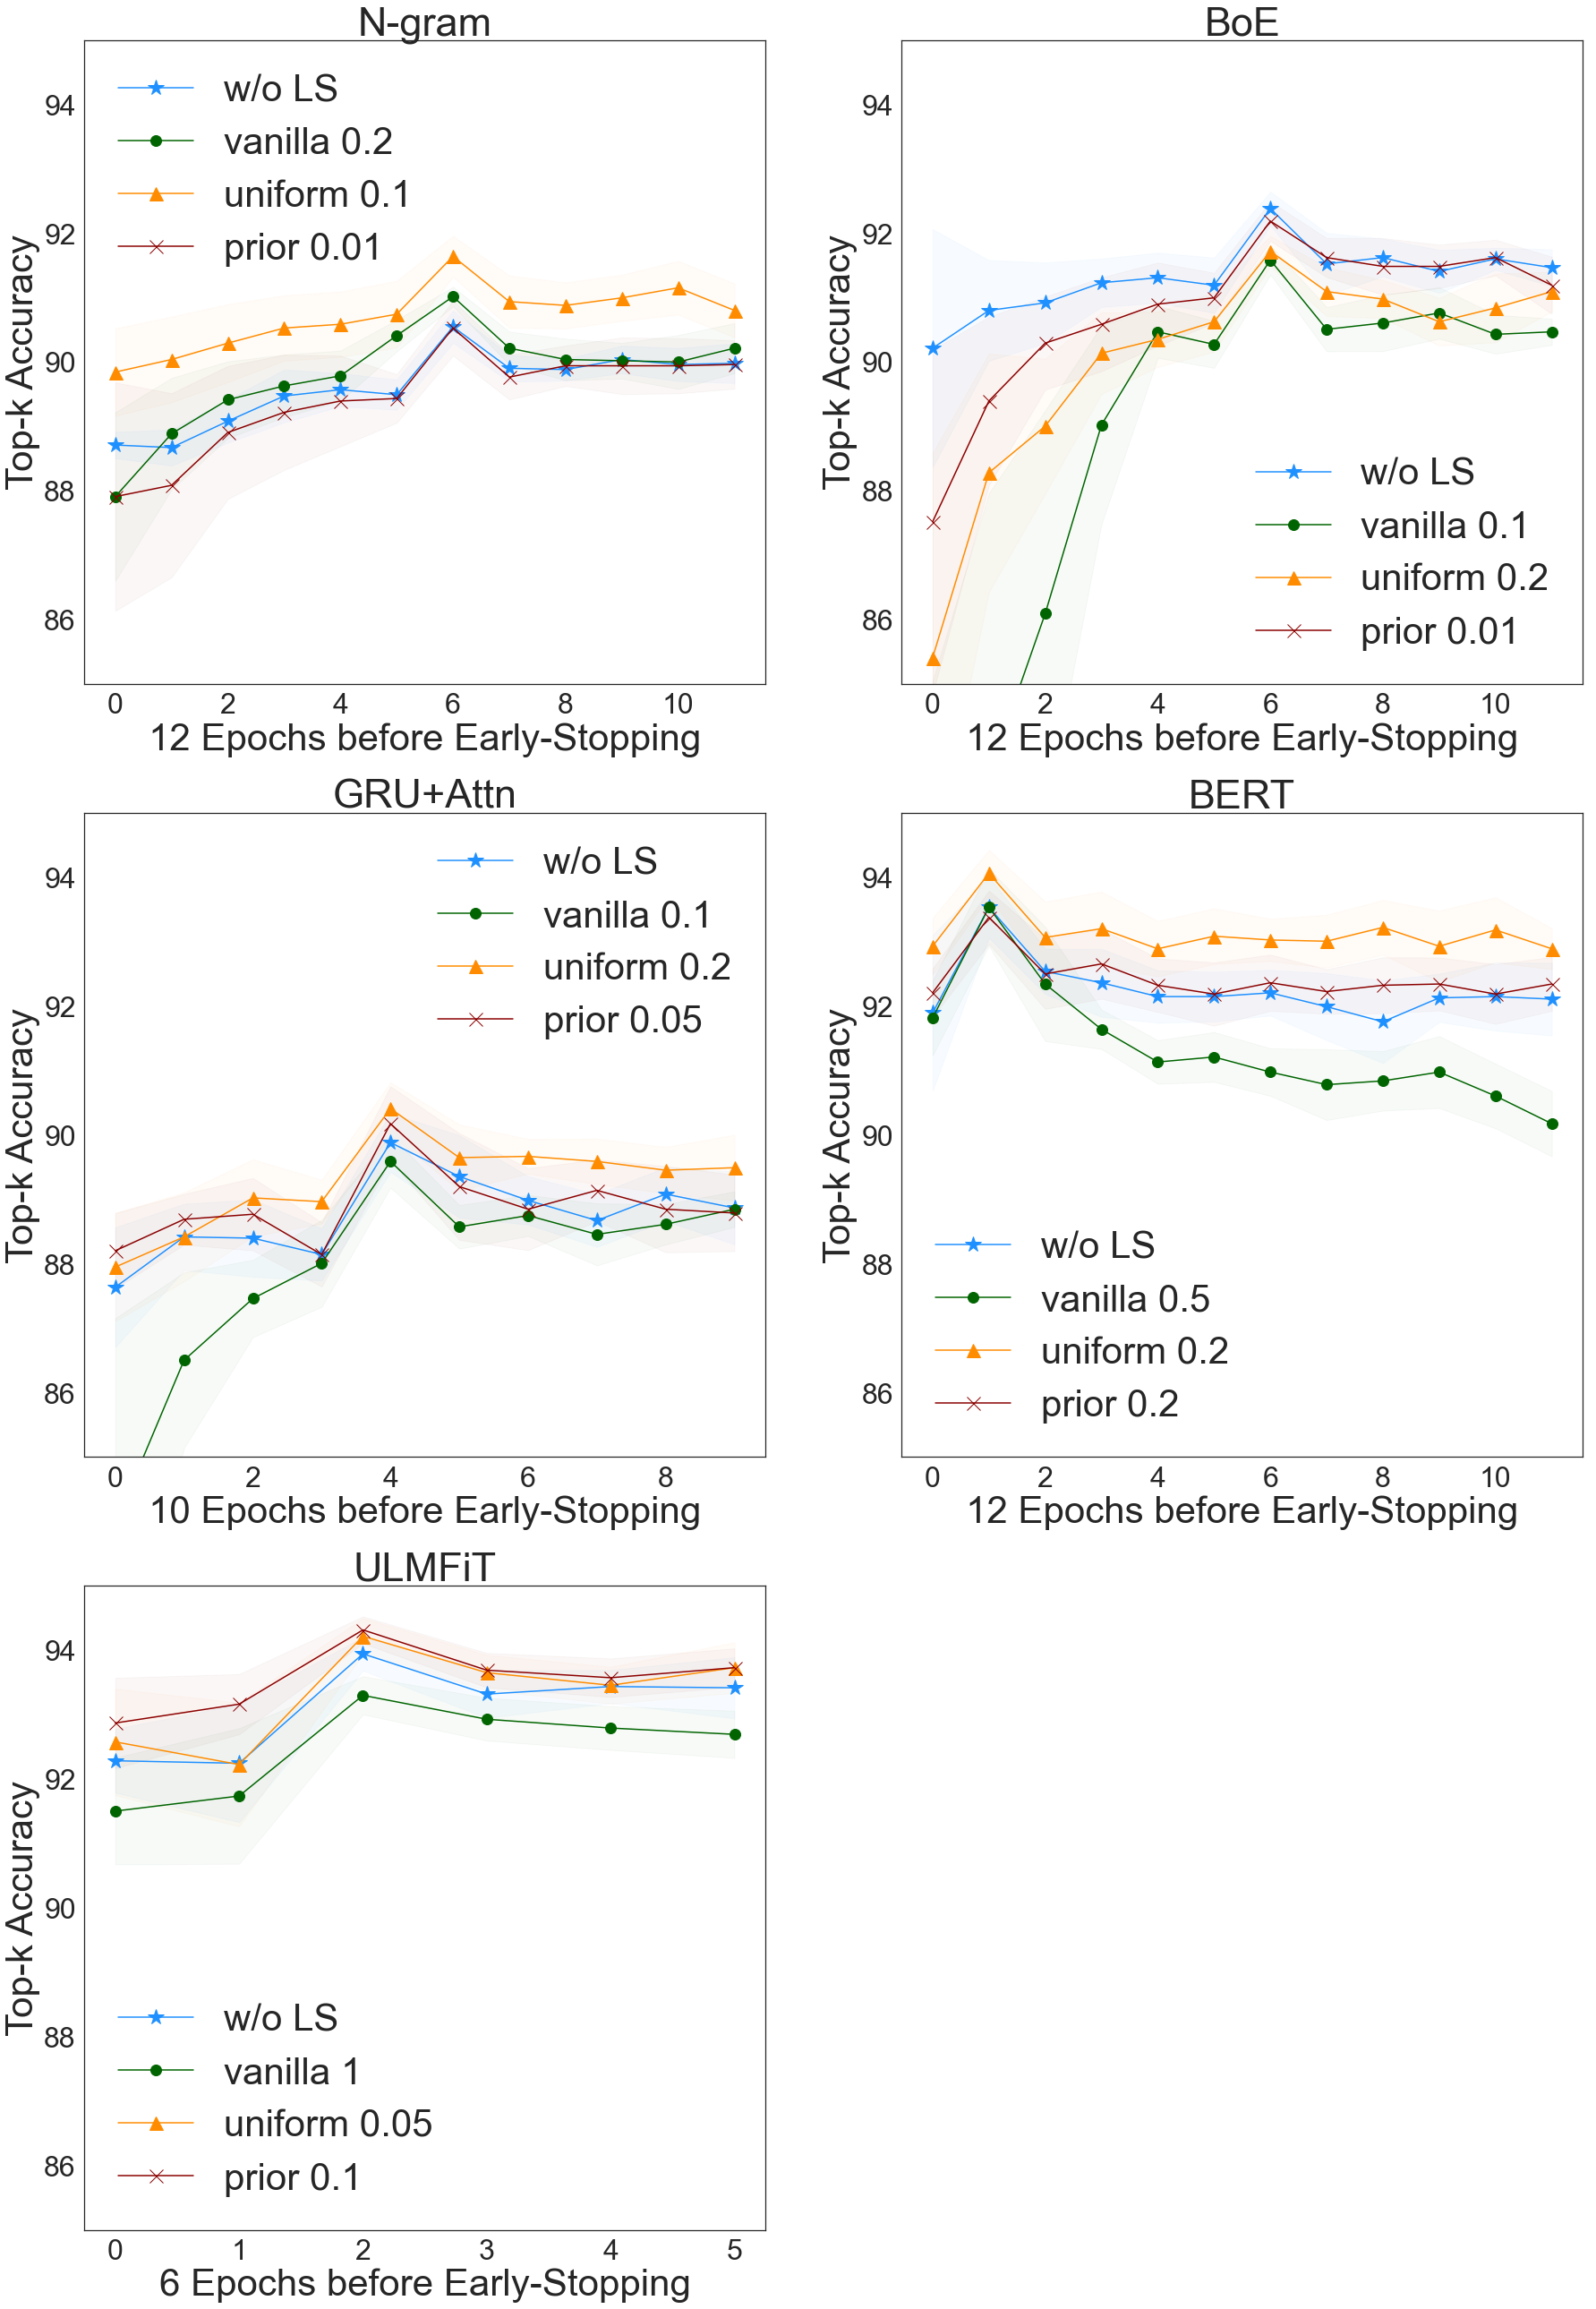

In [32]:
sns.set(style="white")

fig,axes = plt.subplots(3,2,figsize = (30,45),sharex=True, sharey=True)

plt.subplot(321)
draw_sub(exp_df, exp_agg, 'ngram','N-gram')

plt.subplot(322)
draw_sub(exp_df, exp_agg, 'boe','BoE')

plt.subplot(323)
draw_sub(exp_df, exp_agg, 'attn','GRU+Attn',10)

plt.subplot(324)
draw_sub(exp_df, exp_agg, 'bert','BERT')

plt.subplot(325)
draw_sub(exp_df, exp_agg, 'ulmfit','ULMFiT',6)

plt.subplot(326)
plt.box(False)
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off',colors='white')